In [1]:
#Importing all the Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

#Reading the cleaned data 
survey1=pd.read_excel("cleaned_schema_1_data.xlsx")
survey2=pd.read_excel("cleaned_schema_2_data.xlsx")
survey3=pd.read_excel("cleaned_schema_3_data.xlsx")

#Creating a copy of the original data to protect unnecessary modification in original data.
df1=survey1.copy()
df2=survey2.copy()
df3=survey3.copy()


In [2]:
df2.info()
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11723 entries, 0 to 11722
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   11723 non-null  object 
 1   fsa                     11723 non-null  object 
 2   probable                11723 non-null  int64  
 3   vulnerable              11723 non-null  int64  
 4   is_most_recent          11723 non-null  object 
 5   fever_chills_shakes     11723 non-null  int64  
 6   cough                   11723 non-null  int64  
 7   shortness_of_breath     11723 non-null  int64  
 8   any_medical_conditions  11723 non-null  int64  
 9   travel_outside_canada   11723 non-null  int64  
 10  contact_with_illness    11723 non-null  int64  
 11  symptoms                11723 non-null  object 
 12  conditions              11723 non-null  object 
 13  ethnicity               11723 non-null  object 
 14  sex                     11723 non-null

#  Q1. Who should be prioritized for COVID testing and early intervention?
***Reasoning:Individuals reporting key symptom clusters have a higher probability of COVID and should receive testing priority.***
***Prioritize testing for respondents reporting fever and cough, especially when shortness of breath is present.***

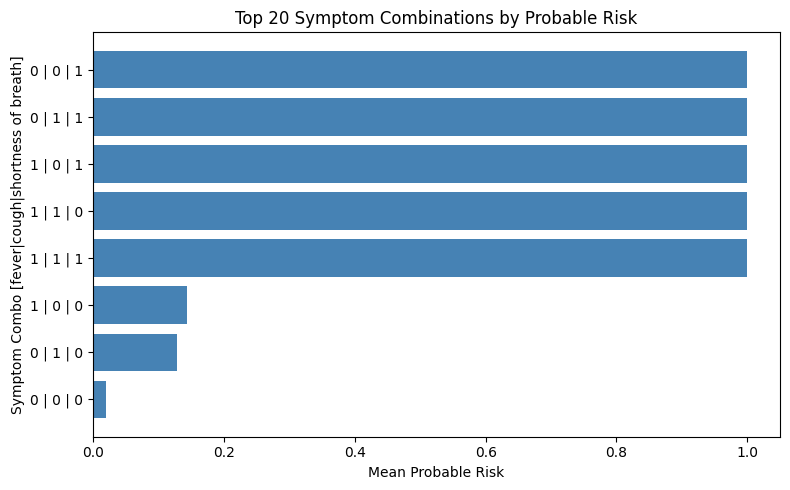

In [3]:
symptoms = ["fever_chills_shakes", "cough", "shortness_of_breath"]

def compute_symptom_risk(df, label):
    return (
        df.groupby(symptoms)["probable"]
          .mean()
          .reset_index()
          .sort_values("probable", ascending=False)
          .head(20)
          .assign(source=label)  # Track origin
    )

risk_df1 = compute_symptom_risk(df1, "df1")
risk_df2 = compute_symptom_risk(df2, "df2")
risk_df3 = compute_symptom_risk(df3, "df3")

combined_symptom_risk = pd.concat(
    [risk_df1, risk_df2, risk_df3],
    ignore_index=True
)


combined_symptom_risk = pd.concat(
    [risk_df1, risk_df2, risk_df3],
    ignore_index=True)

top_symptoms = combined_symptom_risk.head(20).copy()
top_symptoms['symptom_combo'] = (
    top_symptoms['fever_chills_shakes'].astype(str) + " | " +
    top_symptoms['cough'].astype(str) + " | " +
    top_symptoms['shortness_of_breath'].astype(str)
)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(
    top_symptoms['symptom_combo'],
    top_symptoms['probable'],
    color='steelblue'
)

plt.xlabel('Mean Probable Risk')
plt.ylabel('Symptom Combo [fever|cough|shortness of breath]')
plt.title('Top 20 Symptom Combinations by Probable Risk')

# Highest risk on top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Q2.Which demographic groups need targeted public health messaging?
***Reasoning:
Different age groups experience different symptom prevalence and risk levels. Direct prevention campaigns toward age groups with the highest probable COVID rates.***

  Age Group  probable
0       <26  0.023514
1     26-44  0.017238
2     45-64  0.010995
3       >65  0.007319


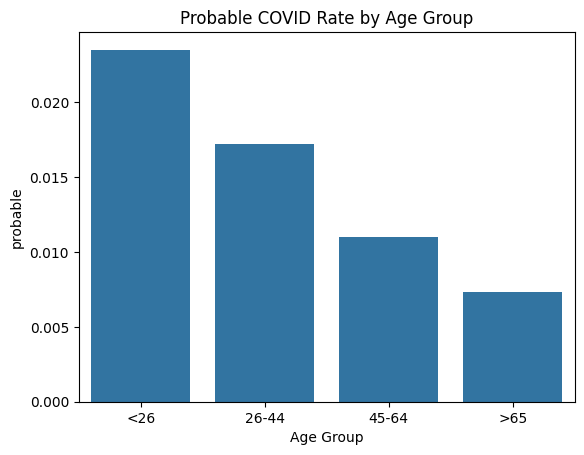

In [4]:
age_prob = []
age_columns = {
    '<26': 'age_1_<26',
    '26-44': 'age_1_26-44',
    '45-64': 'age_1_45-64',
    '>65': 'age_1_>65'
}
def create_age_prob_df(df):
    age_prob_list = []
    for age_group, col in age_columns.items():
        temp = df.loc[df[col] == 1, ['probable']].copy()
        temp['Age Group'] = age_group
        age_prob_list.append(temp)
    return pd.concat(age_prob_list, ignore_index=True)

# Create combined age_vuln_df for multiple datasets
age_prob_df = pd.concat([
    create_age_prob_df(df2),
    create_age_prob_df(df3)
], ignore_index=True)


prob_summary = (
    age_prob_df
    .groupby('Age Group')['probable']
    .mean()
    .reset_index()
)
vuln_summary_sorted = prob_summary.sort_values(
    by='probable',  # column to sort by
    ascending=False   # descending order
).reset_index(drop=True)
print(vuln_summary_sorted)

sns.barplot(data=vuln_summary_sorted, x="Age Group", y="probable")
plt.title("Probable COVID Rate by Age Group")
plt.show()

# Q3.Does traveling outside Canada increase the likelihood of testing positive for COVID-19 among survey respondents?
***Resoning: Respondents who traveled outside Canada had a higher COVID-19 positivity rate compared to those who did not. This suggests a potential link between international travel and infection risk, emphasizing the importance of monitoring travel-related exposure while considering that some test results were unreported.***
*  **This insight can be useful to target testing, vaccination, and isolation measures, ensuring resources are focused on those most likely to be infected and reducing further spread.**

   travel_outside_canada  Total_Responses  Positive_Cases  Positivity_Rate (%)
0                      0              487            21.0             4.312115
1                      1                3             1.0            33.333333


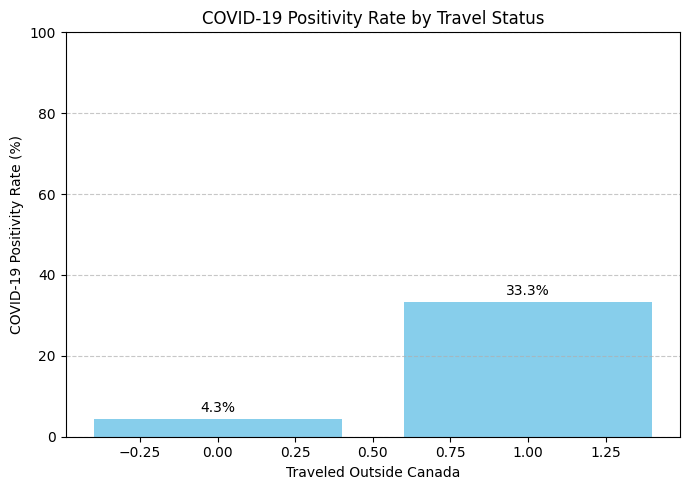

In [9]:
summary = df3.groupby('travel_outside_canada')['covid_positive'].agg(
    Total_Responses='count',        # Counts non-missing covid_positive
    Positive_Cases='sum'            # Sum of 1's in covid_positive
).reset_index()

# Calculate positivity rate
summary['Positivity_Rate (%)'] = (summary['Positive_Cases'] / summary['Total_Responses']) * 100

print(summary)

plt.figure(figsize=(7, 5))

# Bar chart of positivity rate
plt.bar(
    summary['travel_outside_canada'],
    summary['Positivity_Rate (%)'],
    color='skyblue'
)

plt.xlabel('Traveled Outside Canada')
plt.ylabel('COVID-19 Positivity Rate (%)')
plt.title('COVID-19 Positivity Rate by Travel Status')
plt.ylim(0, 100)  # Show as percentage

# Display the exact positivity rate on top of bars
for i, rate in enumerate(summary['Positivity_Rate (%)']):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom')

#lt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))    

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Q4.Who should receive priority mental health interventions?
***Reasoning:
COVID-19 risk is higher among individuals reporting specific needs, particularly medication and financial support, while those reporting no needs show consistently lower risk across vulnerability groups.***
   * **The analysis provides data-driven guidance for allocating resources where they can have the greatest impact in reducing health risk and improving outcomes.**

    vulnerable needs_cleaned  probable
0            0     emotional  0.013397
1            0     financial  0.013867
2            0          food  0.012016
3            0    medication  0.074830
4            0          none  0.010532
5            0         other  0.031818
6            1     emotional  0.018667
7            1     financial  0.038961
8            1          food  0.004000
9            1    medication  0.021978
10           1          none  0.006821
11           1         other  0.000000


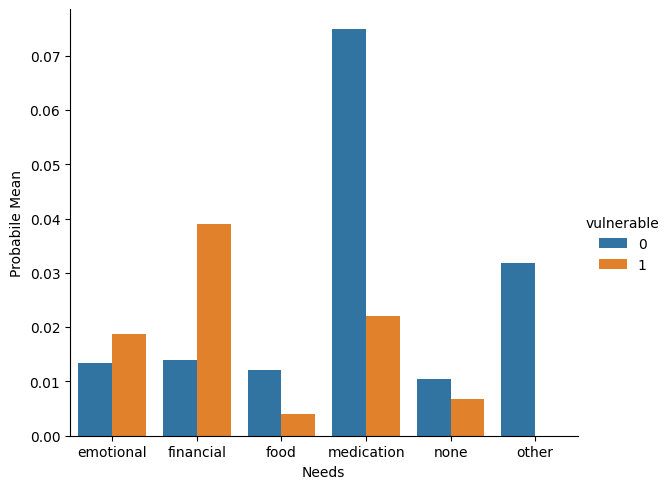

In [10]:
needs_mapping = {
    'noneOfTheAbove': 'none',
    'food': 'food',
    'financialSupport': 'financial',
    'emotionalSupport': 'emotional',
    'other': 'other',
    'medication': 'medication'
}

# Apply mapping
df3['needs_cleaned'] = df3['needs'].map(needs_mapping)
mental_risk = (
    df3.groupby(["vulnerable", "needs_cleaned"])["probable"]
    .mean()
    .reset_index()
)

print(mental_risk)
sns.catplot(
    data=mental_risk,
    x="needs_cleaned",
    y="probable",
    hue="vulnerable",
    kind="bar",
    height=5,
    aspect=1.2
)
plt.xlabel('Needs')
plt.ylabel('Probabile Mean')
plt.show()

# Q5. Does having contact with a known illness increase the likelihood of testing positive for COVID-19 among respondents?
***Resoning: Respondents with contact with a known illness have a much higher COVID-19 positivity rate (16.7%) compared to those with no contact (3.5%), highlighting the increased risk of infection from exposure and the importance of preventive measures.***
*  **This insight can be useful to target testing, vaccination, and isolation measures, ensuring resources are focused on those most likely to be infected and reducing further spread.**

   contact_with_illness  Total_Responses  Positive_Cases  Positivity_Rate (%)
0                     0              454            16.0             3.524229
1                     1               36             6.0            16.666667


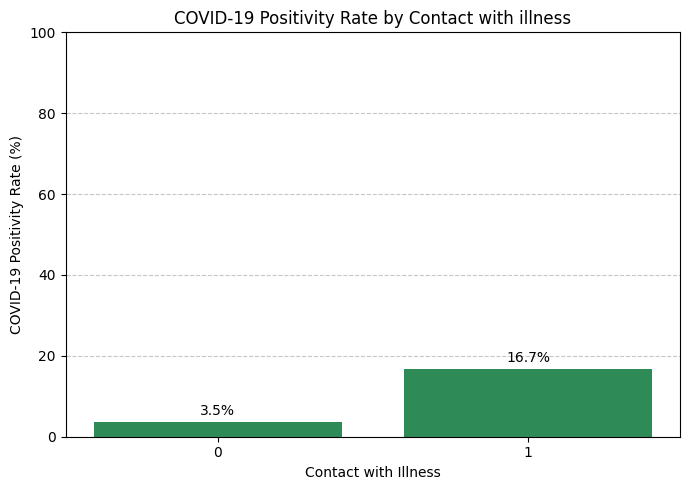

In [11]:
summary = df3.groupby('contact_with_illness')['covid_positive'].agg(
    Total_Responses='count',        # Counts non-missing covid_positive
    Positive_Cases='sum'            # Sum of 1's in covid_positive
).reset_index()

# Calculate positivity rate
summary['Positivity_Rate (%)'] = (summary['Positive_Cases'] / summary['Total_Responses']) * 100

print(summary)

plt.figure(figsize=(7, 5))

# Bar chart of positivity rate
plt.bar(
    summary['contact_with_illness'],
    summary['Positivity_Rate (%)'],
    color='seagreen'
)

plt.xlabel('Contact with Illness')
plt.ylabel('COVID-19 Positivity Rate (%)')
plt.title('COVID-19 Positivity Rate by Contact with illness')
plt.ylim(0, 100)  # Show as percentage

# Display the exact positivity rate on top of bars
for i, rate in enumerate(summary['Positivity_Rate (%)']):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))    

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Q6. Among individuals at higher risk (due to travel outside Canada or contact with illness), how many did not go for COVID-19 testing, and which groups are most affected?
***Resoning:Among high-risk individuals, many did not get tested, with the largest gap seen in those with contact but no travel (104 people). Fewer people who traveled (28) or both traveled and had contact (8) missed testing. Targeted outreach and testing for these exposed groups can help reduce COVID-19 spread.***
* **This analysis pinpoints testing gaps among exposed individuals, allowing health department to act strategically rather than uniformly.**


Not tested by travel and contact combination:
   travel_outside_canada  contact_with_illness  Not_Tested_Count label
1                      0                     1               104   0&1
2                      1                     0                28   1&0
3                      1                     1                 8   1&1


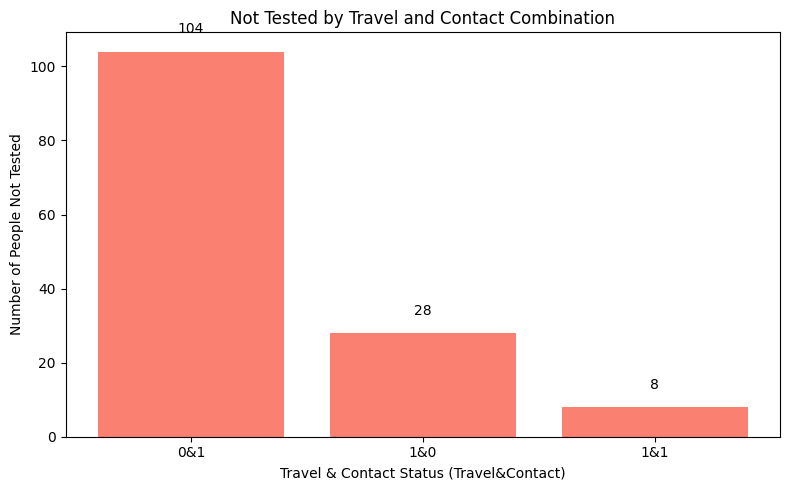

In [18]:

# Create a flag for not tested
df3['not_tested'] = df3['covid_positive'].isna().astype(int)

# Breakdown by travel status
travel_breakdown = (
    df3
    .groupby('travel_outside_canada')['not_tested']
    .sum()
    .reset_index()
    .rename(columns={'not_tested': 'Not_Tested_Count'})
)

# Breakdown by contact with illness
contact_breakdown = (
    df3
    .groupby('contact_with_illness')['not_tested']
    .sum()
    .reset_index()
    .rename(columns={'not_tested': 'Not_Tested_Count'})
)

# Combined breakdown: both travel and contact
combined_breakdown = (
    df3
    .groupby(['travel_outside_canada', 'contact_with_illness'])['not_tested']
    .sum()
    .reset_index()
    .rename(columns={'not_tested': 'Not_Tested_Count'})
)

combined_breakdown['label'] = combined_breakdown.apply(
    lambda row: f"{row['travel_outside_canada']}&{row['contact_with_illness']}", axis=1
)
filtered_combined = combined_breakdown[
    ~((combined_breakdown['travel_outside_canada'] == 0) & 
      (combined_breakdown['contact_with_illness'] == 0))
].copy()

# Create a label column for plotting
filtered_combined['label'] = filtered_combined.apply(
    lambda row: f"{row['travel_outside_canada']}&{row['contact_with_illness']}", axis=1
)

print("\nNot tested by travel and contact combination:")
print(filtered_combined)


#print(filtered_combined)

plt.figure(figsize=(8,5))
plt.bar(
    filtered_combined['label'],
    filtered_combined['Not_Tested_Count'],
    color='salmon'
)
plt.xlabel('Travel & Contact Status (Travel&Contact)')
plt.ylabel('Number of People Not Tested')
plt.title('Not Tested by Travel and Contact Combination')
for i, count in enumerate(filtered_combined['Not_Tested_Count']):
    plt.text(i, count + 5, str(count), ha='center')
plt.tight_layout()
plt.show()

# Q7. How did COVID-19 testing and confirmed positive cases vary month-wise, and what trends can be observed over time?
***Month-wise analysis shows trends in COVID-19 testing and positive cases. Peaks in positive cases do not always align with testing volume, highlighting periods where increased testing or targeted interventions may have been needed. This helps guide resource allocation and outbreak monitoring over time.***
* **Month-wise testing and positivity trends help identify periods of higher infection and gaps in testing. This enables targeted interventions and better allocation of resources to control the spread of COVID-19**

  covid_results_date  Total_Testing  Positive_Cases  Positivity_Rate (%)
0           February              4             0.0             0.000000
1              March             54             0.0             0.000000
2              April            123            15.0            12.195122
3                May            116             6.0             5.172414
4               June             94             0.0             0.000000
5               July             30             0.0             0.000000


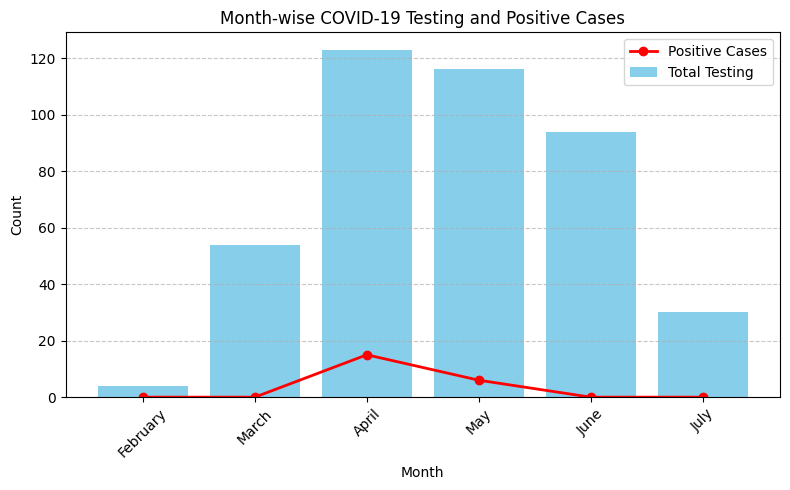

In [13]:
monthwise_summary = df3.groupby('covid_results_date')['covid_positive'].agg(
    Total_Testing='count',      # total responses in the month
    Positive_Cases='sum'           # total positive cases
).reset_index()

# Calculate positivity rate
monthwise_summary['Positivity_Rate (%)'] = (
    monthwise_summary['Positive_Cases'] / monthwise_summary['Total_Testing'] * 100
)

# Define correct month order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November', 'December'
]

# Correct any spelling issues in your data
monthwise_summary['covid_results_date'] = monthwise_summary['covid_results_date'].replace({
    'Feburary': 'February'  # fix spelling
})

# Convert to categorical with ordered months
monthwise_summary['covid_results_date'] = pd.Categorical(
    monthwise_summary['covid_results_date'],
    categories=month_order,
    ordered=True
)

# Sort by month
monthwise_summary = monthwise_summary.sort_values('covid_results_date').reset_index(drop=True)

print(monthwise_summary)


plt.figure(figsize=(8,5))

# Bar chart: Total Responses
plt.bar(
    monthwise_summary['covid_results_date'].astype(str),
    monthwise_summary['Total_Testing'],
    color='skyblue',
    label='Total Testing'
)

# Line chart: Positive Cases
plt.plot(
    monthwise_summary['covid_results_date'].astype(str),
    monthwise_summary['Positive_Cases'],
    color='red',
    marker='o',
    linewidth=2,
    label='Positive Cases'
)

# Labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Month-wise COVID-19 Testing and Positive Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


# Q8. Who should be targeted for increased COVID testing on basis of symptoms and contact with illness?
***Resoning: Increase testing coverage among high-risk groups. According to result there are may persons who has been in contact with illness and had covid like symptoms but did not gone for testing.***

            Mean_Contact_with_Illness  Mean_Fever  Mean_Cough  \
not_tested                                                      
0                            0.073469    0.069388    0.069388   
1                            0.007445    0.007245    0.012696   

            Mean_Shortness_of_Breath  
not_tested                            
0                           0.067347  
1                           0.009040  


<Figure size 800x500 with 0 Axes>

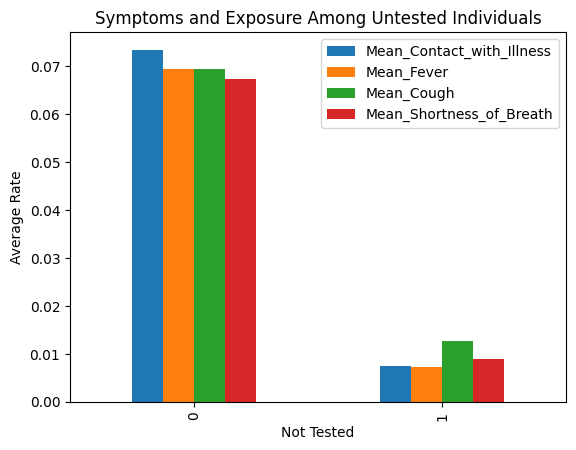

In [22]:
df3['not_tested'] = df3['covid_positive'].isna().astype(int)
testing_gap = df3.groupby('not_tested')[['contact_with_illness', 'symp_fever','symp_cough','symp_shortnessOfBreath']].mean()
testing_gap = testing_gap.rename(columns={
    'contact_with_illness': 'Mean_Contact_with_Illness',
    'symp_fever': 'Mean_Fever',
    'symp_cough': 'Mean_Cough',
    'symp_shortnessOfBreath': 'Mean_Shortness_of_Breath'
})

print(testing_gap)

# Plot
plt.figure(figsize=(8,5))

testing_gap.plot(kind='bar')
plt.xlabel('Not Tested')
plt.ylabel('Average Rate')
plt.title('Symptoms and Exposure Among Untested Individuals')
plt.show()

In [43]:
def get_age_group(row):
    if row['age_1_<26'] == 1:
        return '<26'
    elif row['age_1_26-44'] == 1:
        return '26-44'
    elif row['age_1_45-64'] == 1:
        return '45-64'
    elif row['age_1_>65'] == 1:
        return '>65'

'''

df2['age_group'] = df2.apply(get_age_group, axis=1)
df2['sex'] = df2['sex'].notna() & (df2['sex'].str.strip() != '')

sex_prob = df2_filtered.groupby('sex')['probable'].mean()

print(df2['sex'].unique())
'''
df2_filtered = df2[
    df2['sex'].notna() & (df2['sex'].str.strip() != '')
]

sex_prob = df2_filtered.groupby('sex')['probable'].mean()
print(sex_prob)

plt.figure()
plt.bar(sex_prob.index, sex_prob.values)
plt.xlabel('Sex')
plt.ylabel('Probability of Probable COVID')
plt.title('COVID Probability by Sex')
plt.show()

age_prob = df2.groupby('age_group')['probable'].mean()

print(age_prob)

plt.figure()
plt.bar(age_prob.index, age_prob.values)
plt.xlabel('Age Group')
plt.ylabel('Probability of Probable COVID')
plt.title('COVID Probability by Age Group')
plt.show()

medical_prob = df2.groupby('any_medical_conditions')['probable'].mean()
#medical_prob.index = ['No Medical Condition', 'Has Medical Condition']

print(medical_prob)

plt.figure()
plt.bar(medical_prob.index, medical_prob.values)
plt.xlabel('Medical Condition Status')
plt.ylabel('Probability of Probable COVID')
plt.title('COVID Probability by Medical Condition')
plt.show()

combined_prob = (
    df2
    .groupby(['sex', 'age_group', 'any_medical_conditions'])['probable']
    .mean()
    .reset_index()
)

combined_prob['any_medical_conditions'] = combined_prob['any_medical_conditions'].map({
    0: 'No Medical Condition',
    1: 'Has Medical Condition'
})

print(combined_prob.head(10))

high_risk = combined_prob.sort_values('probable', ascending=False).head(10)

plt.figure()
plt.barh(
    high_risk.apply(lambda x: f"{x['sex']} | {x['age_group']} | {x['any_medical_conditions']}", axis=1),
    high_risk['probable']
)
plt.xlabel('Probability of Probable COVID')
plt.title('Top High-Risk Demographic Groups')
plt.gca().invert_yaxis()
plt.show()

AttributeError: Can only use .str accessor with string values!